In [139]:
import pickle as pk
import matplotlib.pyplot as plt
import numpy as np
import glob
import matchms
from matchms.plotting import plot_spectra_mirror
from scipy.optimize import curve_fit

In [4]:
fname = 'checkpoints/small.80173081.validate_.00000600.output'

with open(fname,'rb') as f:
    p = pk.load(f)

In [6]:
p.keys()

dict_keys(['timing', 'running_loss', 'total_points', 'mean_loss', 'runtime', 'compute_time', 'run_efficiency', 'pts_per_sec', 'pred_spect', 'pred_formulae_probs', 'pred_input_idx', 'pred_input_mask', 'pred_true_spect', 'pred_formulae_features', 'pred_vert_element_oh'])

2023-03-30 14:30:20,100:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-03-30 14:30:20,101:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


<Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>

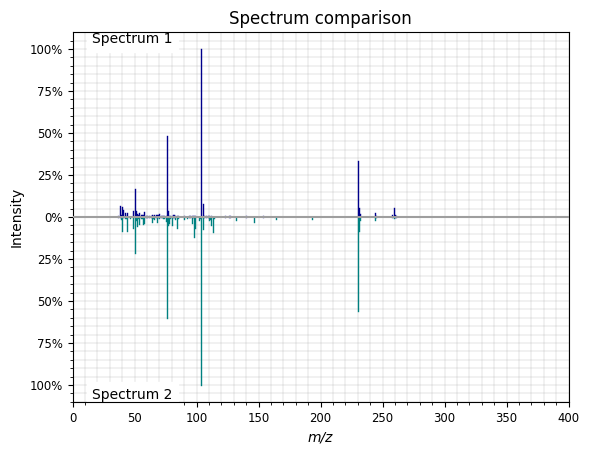

In [52]:
def to_matchms_spec(s):
    mzp = np.nonzero(s)[0]
    intp = s[mzp]
    return matchms.Spectrum(mz=mzp.astype(float), intensities = intp.astype(float))

idx = 42
spp = to_matchms_spec(p['pred_spect'][idx])
spt = to_matchms_spec(p['pred_true_spect'][idx])

plot_spectra_mirror(spp,spt)


In [54]:
matchms.set_matchms_logger_level("ERROR")

true = p['pred_true_spect']
pred = p['pred_spect']
n = len(true)

sim_dp = matchms.similarity.CosineGreedy(mz_power=1., intensity_power=.5)
dp = [ sim_dp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(n) ]
dp = np.array([ float(s['score']) for s in dp ])

sim_sdp = matchms.similarity.CosineGreedy(mz_power=3., intensity_power=.6)
sdp = [ sim_sdp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(n) ]
sdp = np.array([ float(s['score']) for s in sdp ])


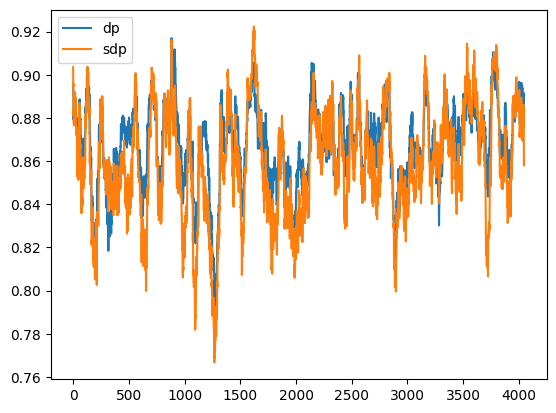

In [55]:
win = 50
smooth_dp = np.convolve(dp, np.ones(win)/win, mode='valid')
smooth_sdp = np.convolve(sdp, np.ones(win)/win, mode='valid')

plt.plot(smooth_dp,label='dp')
plt.plot(smooth_sdp,label='sdp')
plt.legend()
#plt.plot([ float(s['matches']) for s in scores ])
plt.show()

In [56]:
np.mean(dp),np.std(dp)

(0.8676173198727783, 0.12075006851354393)

In [134]:
dps = {}
sdps = {}


In [269]:
for fn in sorted(glob.glob('checkpoints/*validate*.output')):
#for fn in sorted(glob.glob('checkpoints/*train*.output')):
    if fn in dps:
        continue
        
    with open(fn,'rb') as pf:
        p = pk.load(pf)
    
    true = p['pred_true_spect']
    pred = p['pred_spect']
    n = len(true)

    dp = [ sim_dp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(n) ]
    dps[fn] = np.array([ float(s['score']) for s in dp ])
     
    sdp = [ sim_sdp.pair(to_matchms_spec(true[i]),to_matchms_spec(pred[i])) for i in range(n) ]
    sdps[fn] = np.array([ float(s['score']) for s in sdp ])
    


    

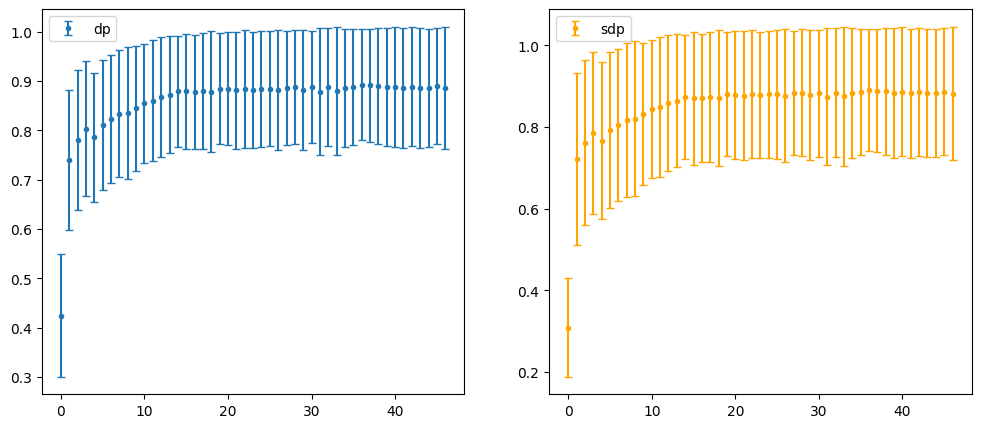

In [270]:
mean_dps = [ np.mean(dps[f]) for f in sorted(dps.keys()) ]
std_dps = [ np.std(dps[f]) for f in sorted(dps.keys()) ]
mean_sdps = [ np.mean(sdps[f]) for f in sorted(sdps.keys()) ]
std_sdps = [ np.std(sdps[f]) for f in sorted(sdps.keys()) ]

plt.figure(figsize=(12,5))
l = len(dps)
plt.subplot(121)
plt.errorbar(x=range(l),y=mean_dps,yerr=std_dps,label='dp',linestyle='None', marker='.',capsize=3)
plt.legend()
plt.subplot(122)
plt.errorbar(x=range(l),y=mean_sdps,yerr=std_sdps,label='sdp',color='orange',linestyle='None', marker='.',capsize=3)
plt.legend()
plt.show()


In [271]:
i=np.argmax(mean_dps)
i,mean_dps[i],std_dps[i]

(36, 0.8923131723854508, 0.11262177700133502)

In [272]:
i=np.argmax(mean_sdps)
i,mean_sdps[i],std_sdps[i]

(36, 0.8900633959848978, 0.14915642167243912)

In [273]:
len(dps)

47

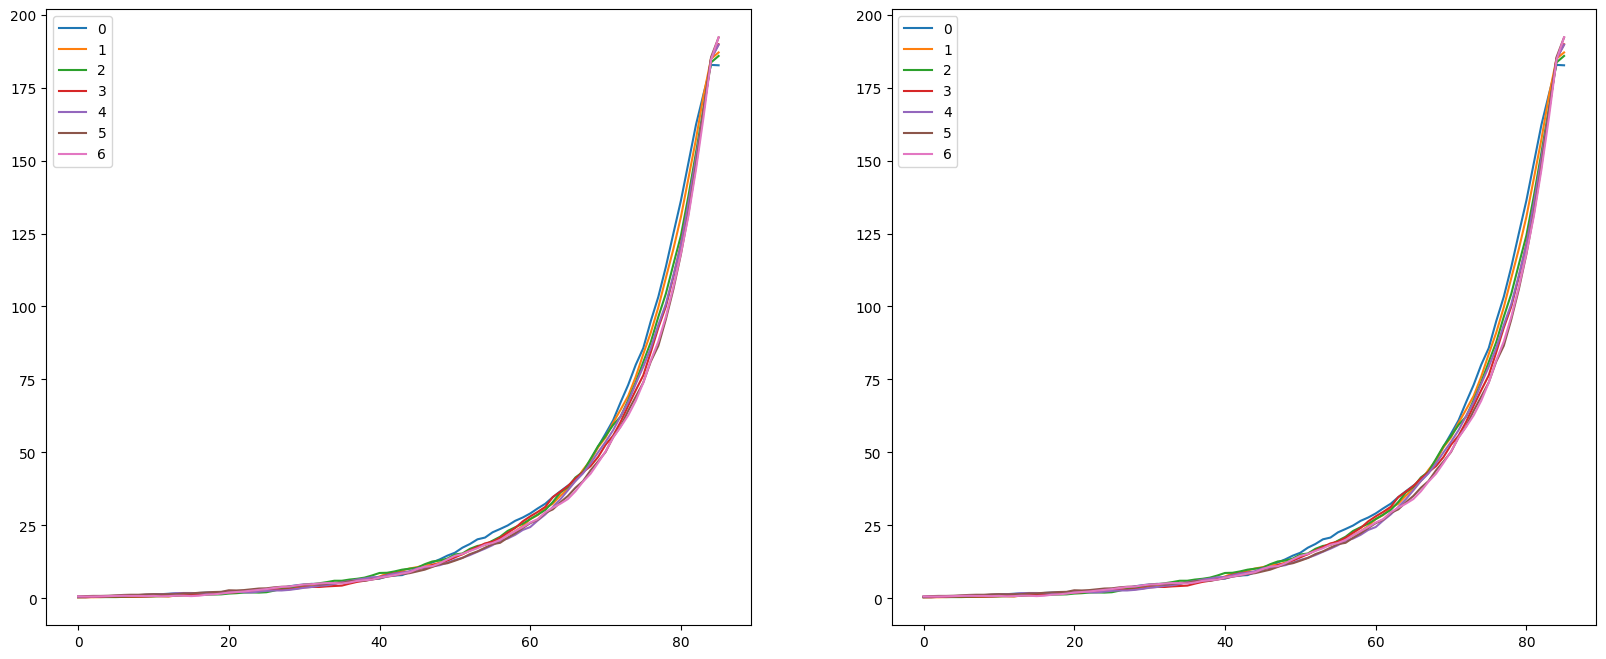

In [268]:
bins = 100
plt.figure(figsize=(20,8))

win=15
first=15
step=5
plt.subplot(121)
for i,fn in enumerate(sorted(dps.keys())[first::step]):
    counts, bins = np.histogram(dps[fn],bins=bins)
    counts = np.convolve(counts, np.ones(win)/win, mode='valid')
#    plt.stairs(counts, bins, label=str(i))
    plt.plot(counts,label=str(i))

plt.legend()

plt.subplot(122)
for i,fn in enumerate(sorted(dps.keys())[first::step]):
    counts, bins = np.histogram(dps[fn],bins=bins)
    counts = np.convolve(counts, np.ones(win)/win, mode='valid')
#    plt.stairs(counts, bins, label=str(i))
    plt.plot(counts,label=str(i))

    
plt.legend()
plt.show()

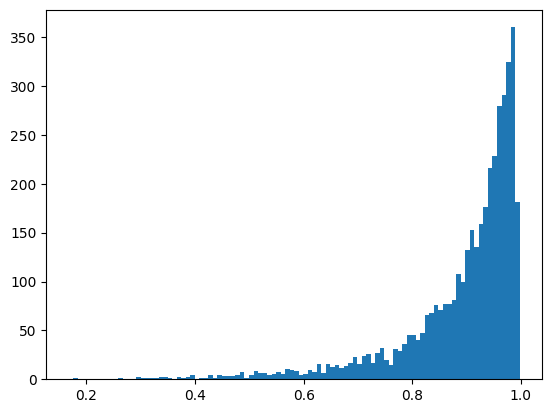

In [275]:
dp_best = dps[list(sorted(dps.keys()))[36]]

plt.hist(dp_best,bins=bins)
plt.show()

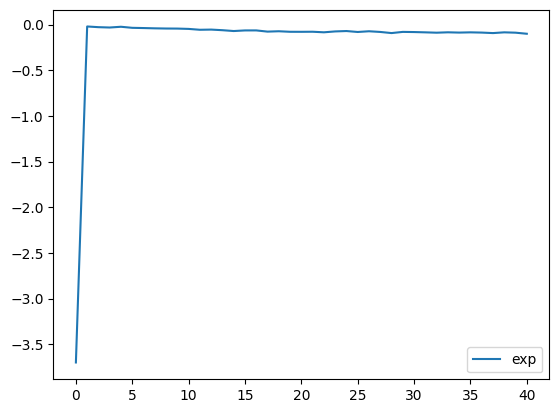

In [253]:
def expf(x,a,b):
    return b*np.exp(a*x)

e = []

for fn in sorted(dps.keys()):

    x = np.linspace(0,99,100)
    #dphist = np.flip(np.histogram(dps[fn],bins=100)[0])
    dphist = np.flip(np.histogram(dps[fn],bins=100)[0])

    e.append(curve_fit(expf,x,dphist,[-1.,200.])[0])
    
e = np.array(e)

plt.plot(e[:,0],label='exp')
#plt.plot(e[:,1],label='scale')
plt.legend()

plt.show()

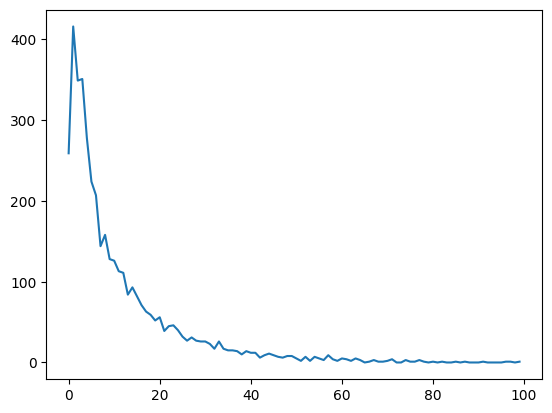

In [252]:
plt.plot(x,dphist)
plt.show()

In [250]:
dphist

array([259, 416, 349, 351, 278, 224, 207, 144, 158, 128, 126, 113, 111,
        84,  93,  82,  71,  63,  59,  52,  56,  39,  45,  46,  40,  32,
        27,  31,  27,  26,  26,  23,  17,  26,  17,  15,  15,  14,  10,
        14,  12,  12,   6,   9,  11,   9,   7,   6,   8,   8,   5,   2,
         7,   2,   7,   5,   3,   9,   4,   2,   5,   4,   2,   5,   3,
         0,   1,   3,   1,   1,   2,   4,   0,   0,   3,   1,   1,   3,
         1,   0,   1,   0,   1,   0,   0,   1,   0,   1,   0,   0,   0,
         1,   0,   0,   0,   0,   1,   1,   0,   1])

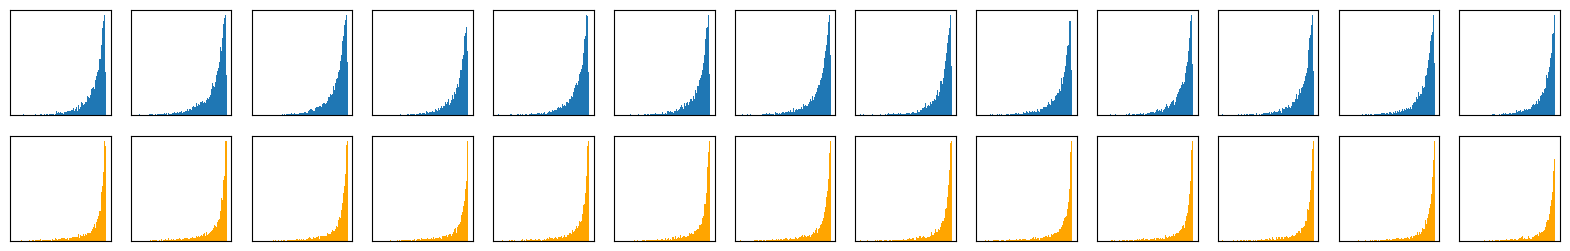

In [218]:
bins = 100
plt.figure(figsize=(20,3))

first=25
l = len(dps)-first
for i,fn in enumerate(sorted(dps.keys())[first:]):
    plt.subplot(2,l,i+1)
    plt.hist(dps[fn],label='dp',bins=bins)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(2,l,l+i+1)
    plt.hist(sdps[fn],label='sdp',bins=bins,color='orange')
    plt.xticks([])
    plt.yticks([])
#lt.legend()
plt.show()

In [129]:
import pandas as pd
smalltrain = pd.read_parquet('smalltrain.pq')
smalltrain

,rdmol,spect,smiles
1,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[27.0, 37.97], [28.0, 8.99], [29.0, 2.0], [30...",CCCC(=O)NC1=CC=CC=C1
2,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[41.0, 370.67], [42.0, 999.0], [43.0, 247.78]...",CC(CC#N)N1CC1
3,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[41.0, 181.84], [42.0, 105.9], [43.0, 251.77]...",C1=CC2=C(NC3=C(C=C(C=C3)CN)C(=O)N2)N=C1
4,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[35.0, 2.0], [36.0, 3.0], [37.0, 5.99], [38.0...",CC1=NN=C(O1)CCC(=O)O
10,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[26.0, 1.0], [28.0, 1.0], [39.0, 3.0], [41.0,...",COC1=CC=CC=C1OC(=O)C=CC(=O)OCC2=CC3=CC=CC=C3C=C2
...,...,...,...
197104,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[31.0, 61.94], [35.0, 84.92], [36.0, 78.93], ...",O=P(Cl)(Cl)Cl
197107,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[51.0, 134.88], [55.0, 33.97], [65.0, 38.96],...",CC(C)NC=CC1=CC(=C(C=C1)O)O
197108,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[41.0, 9.99], [42.0, 29.97], [43.0, 9.99], [4...",CN(C)C(=O)C1=CC=CC2=CC=CC=C21
197110,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[11.0, 0.5], [12.0, 0.5], [13.0, 1.0], [14.0,...",CC1=CC=C(S1)C


In [131]:
len(smalltrain)/4096/1400

0.01965488978794643

In [133]:
4096*1400/len(smalltrain)

50.87792456680478